### Importing required packages

In [114]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from collections import Counter, OrderedDict
from torchtext.vocab import vocab
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [112]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Some Hyperparameters

In [84]:
VOCAB_SIZE = 25000
MAX_LENGTH = 512
BATCH_SIZE = 32

### Importing data

In [2]:
df = pd.read_csv('data/imdb_data.csv')
df.head()

,Review,Rating,Sentiment
0,Imagine The Big Chill with a cast of twenty-so...,2,0
1,I'd have to say that I've seen worse Sci Fi Ch...,3,0
2,Director Fabio Barreto got a strange Academy N...,1,0
3,Pretty bad PRC cheapie which I rarely bother t...,4,0
4,This is a very intriguing short movie by David...,8,1


In [10]:
X = df['Review'].values 
y = df['Sentiment'].values 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

### Text Preprocessing

In [4]:
def tokenizer(text):
    # Replacing n't with not since it could be really important in sentiment analysis
    text = re.sub("n't", ' not ', text)
    # Removing URLs
    text = re.sub('(http).*\/', ' ', text)
    # Removing HTML tags
    text = re.sub('<[^>]*>', '', text)
    # Extracting emoticons
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|P|D|]|})', text)
    # Removing punctuations
    text = re.sub('[\W]+', ' ', text.lower())
    # Adding emoticons at end and converting :-) to :)
    text = text + ' ' + ' '.join(emoticons).replace('-', '')
    
    return text.split()

Vocabulary size = 70866


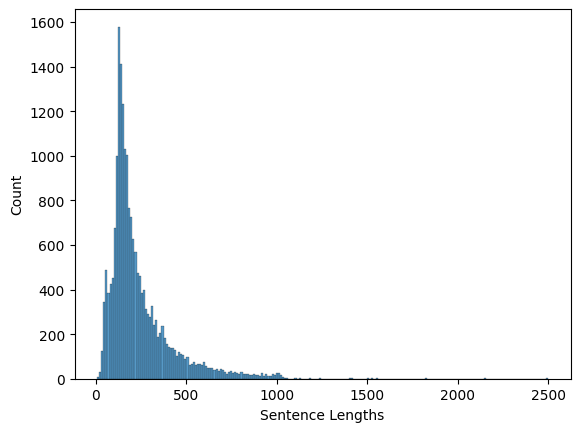

In [48]:
token_counter = Counter()
lengths = []
for review in X_train:
    tokens = tokenizer(review)
    lengths.append(len(tokens))
    token_counter.update(tokens)
print(f'Vocabulary size = {len(token_counter)}')
sns.histplot(lengths)
plt.xlabel('Sentence Lengths')
plt.show()

### Creating vocabulary

In [55]:
token_counter = Counter()
for review in X_train:
    token_counter.update(tokenizer(review))
print(f'Original Vocabulary size = {len(token_counter)}')
sorted_by_freq_tuples = sorted(token_counter.items(), key=lambda x: x[1], reverse=True)[:VOCAB_SIZE]
ordered_dict = OrderedDict(sorted_by_freq_tuples)
PADDING_TOKEN = '<pad>'
UNKNOWN_TOKEN = '<unk>'
specials = [PADDING_TOKEN, UNKNOWN_TOKEN]
vocabulary = vocab(ordered_dict, specials=specials)
vocabulary.set_default_index(vocabulary[UNKNOWN_TOKEN])
print(f'Vocabulary size (after only taking frequent words) = {len(vocabulary)}')

Original Vocabulary size = 70866
Vocabulary size (after only taking frequent words) = 25002


### Padding

In [63]:
def padding(array, desired_length):
    array_length = len(array)
    if (array_length >= desired_length):
        return array[:desired_length]
    else:
        diff = desired_length - array_length 
        return np.pad(array,(diff, 0), 'constant',constant_values=(vocabulary['<pad>']))

### Embedding

In [79]:
def get_embedding(text_array):
    X = []
    for review in text_array:
        tokens = tokenizer(review)
        embedding = np.array([vocabulary[token] if token in vocabulary else vocabulary['<unk>'] for token in tokens])
        padded_embedding = padding(embedding, MAX_LENGTH)
        X.append(padded_embedding)
    return np.array(X)

In [82]:
X_train_embedded = get_embedding(X_train)
X_test_embedded = get_embedding(X_test)
X_valid_embedded = get_embedding(X_valid)

### Train and Valid DataLoaders

In [129]:
train_data = torch.utils.data.TensorDataset(torch.tensor(X_train_embedded), torch.tensor(y_train).unsqueeze(1).float())
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

valid_data = torch.utils.data.TensorDataset(torch.tensor(X_valid_embedded), torch.tensor(y_valid).unsqueeze(1).float())
valid_loader = torch.utils.data.DataLoader(dataset=valid_data,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

### Training

In [115]:
def training(model, model_name, loss_fn, optimizer, scheduler, train_data_loader, valid_data_loader, num_epochs = 25, patience = 5):
    max_acc = 0.0
    count = 0
    history = []
    for epoch in tqdm(range(num_epochs)):
        model.train()
        train_loss = 0.0
        train_acc = 0.0 
        
        valid_loss = 0.0
        valid_acc = 0.0
        for _, (inputs, labels) in enumerate(train_data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            y_preds = model(inputs)
            loss = loss_fn(y_preds, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*len(inputs)
            correct_counts = (torch.argmax(y_preds.data, 1) == labels).float().sum().item()
            train_acc += correct_counts
        
        with torch.no_grad():
            model.eval()
            for _, (inputs, labels) in enumerate(valid_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                y_preds = model(inputs)
                loss = loss_fn(y_preds, labels)
                valid_loss += loss.item()*len(inputs)
                correct_counts = (torch.argmax(y_preds.data, 1) == labels).float().sum().item()
                valid_acc += correct_counts
        
        train_loss = train_loss/len(train_data_loader.dataset)
        train_acc = train_acc/len(train_data_loader.dataset)
        
        valid_loss = valid_loss/len(valid_data_loader.dataset)
        valid_acc = valid_acc/len(valid_data_loader.dataset)
        
        history.append([train_acc, train_loss, valid_acc, valid_loss]) 
        print(f'Epoch No. {epoch+1}')
        print(f'Training Accuracy = {train_acc:.4f}, Loss = {train_loss:.4f}')
        print(f'Validation Accuracy = {valid_acc:.4f}, Loss = {valid_loss:.4f}')
        torch.save(model.state_dict(), model_name + '_last_epoch.pt')
        
        scheduler.step(valid_loss)
        
        if (valid_acc > max_acc):
            count = 0 
            max_acc = valid_acc 
            torch.save(model.state_dict(), model_name + '_best_model.pt')
        
        else:
            count += 1
            if (count >= patience):
                print(f'Early stop at Epoch Number. {epoch + 1}')
                break 
        
    return model, history

### Accuracy for Test Data

In [131]:
test_data = torch.utils.data.TensorDataset(torch.tensor(X_test_embedded), torch.tensor(y_test).unsqueeze(1).float())
test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

In [132]:
def get_accuracy(trained_model, loss_fn, test_data_loader):
    test_loss = 0.0
    test_acc = 0.0
    with torch.no_grad():
        trained_model.eval()
        for _, (inputs, labels) in enumerate(test_data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            y_preds = trained_model(inputs)
            loss = loss_fn(y_preds, labels)
            test_loss += loss.item()*len(inputs)
            correct_counts = (torch.argmax(y_preds.data, 1) == labels).float().sum().item()
            test_acc += correct_counts
    test_loss = test_loss/len(test_data_loader.dataset)
    test_acc = test_acc/len(test_data_loader.dataset)
    print(f'Loss for test set = {test_loss:.4f}')
    print(f'Accuracy for test set = {test_acc:.4f}')
    return test_loss, test_acc

### Post Training

In [133]:
def post_training(trained_model, loss_fn, test_loader, history, model_name):
    test_loss, test_acc = get_accuracy(trained_model, loss_fn, test_loader)
    history_np = np.array(history)
    fig, axes = plt.subplots(1, 2, figsize = (12, 4))
    epochs_list = np.arange(1, len(history_np)+1)
    axes[0].plot(epochs_list, history_np[:, 0], label = "Training Accuracy", marker = '.')
    axes[0].plot(epochs_list, history_np[:, 2], label = "Validation Accuracy", marker = '.')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()

    axes[1].plot(epochs_list, history_np[:, 1], label = "Training Loss", marker = '.')
    axes[1].plot(epochs_list, history_np[:, 3], label = "Validation Loss", marker = '.')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend()

    fig.suptitle(f'Training for {model_name}')
    plt.show()
    return test_loss, test_acc

### LSTM Model

In [105]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size_1, hidden_size_2, n_layers):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_size)
        self.lstm = nn.LSTM(input_size=embed_size, hidden_size=hidden_size_1, num_layers=n_layers, dropout=0.1, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size_1, hidden_size_2 ),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_size_2, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out 
        

In [113]:
model = LSTM(vocab_size=len(vocabulary), embed_size = 1024, hidden_size_1=512, hidden_size_2=256, n_layers=2)
learning_rate = 0.001
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
num_epochs = 10
patience = 5
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
model.to(device)
print(model)

LSTM(
  (embedding): Embedding(25002, 1024)
  (lstm): LSTM(1024, 512, num_layers=2, batch_first=True, dropout=0.1)
  (fc): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=1, bias=True)
    (4): Sigmoid()
  )
)


In [ ]:
trained_model , history_model = training(model, 'LSTM', loss_fn, optimizer, scheduler, train_loader, valid_loader, num_epochs, patience)

In [ ]:
test_loss_2, test_acc_2 = post_training(trained_model, loss_fn, test_loader, history_model, 'LSTM')